# Upgrading and a Tour of v0.17

This notebook provides a tour of prysm v0.17 and demonstrates the new features and updates made in this release.  It also serves as a guide to upgrading your code from v0.16 to v0.17.  In general, if you use prysm as an embedded modeling or analysis tool you probably need to make few to no changes and your code will still run and produce the same outputs.  One-off scripts will probably require changes.  In practical terms thsi really means your old scripts will need to be pinned to v0.16.1 and new scripts can use v0.17 since there is little reason to upgrade old single-use code.  This can be done by creating two virtual (or conda) environments with each version of prysm, and just activating the one containing prysm v0.16 if you need to look at your old code again (identifying it by looking at the last modified or created date).


We begin as usual by importing a few things:

In [1]:
import numpy as np

from prysm import sample_files, Interferogram, NollZernike, PSF, MTF, config


from matplotlib import pyplot as plt
%matplotlib inline

The [release notes](./v0.17.html) for this release may make it seem like all of your code is broken by upgrading to this release.   Here we hope to quell some of that fear, and show that the core functionality of prysm still behaves the same (and is even a little bit faster).

## Table of Contents

- [Guide to Upgrading](#Guide-to-Upgrading)
- [New Features](#New-Features)


## Guide to Upgrading

First up, propagations still work the same:

In [2]:
# this looks the same as it always has and causes no errors
pu = NollZernike(np.random.rand(36) / 8, opd_unit='waves')  # opd_unit => z_unit (see warning)
ps = PSF.from_pupil(pu, 2)
mt = MTF.from_psf(ps)

/Users/bdube/Open Source/prysm/prysm/_phase.py:46: UserWarning: opd_unit is deprecated, please use z_unit
  warnings.warn('opd_unit is deprecated, please use z_unit')


If you want to poke and prod at the data, you will encounter changes.  In prysm v0.16, you might have done something like this:

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1ba352d0>)

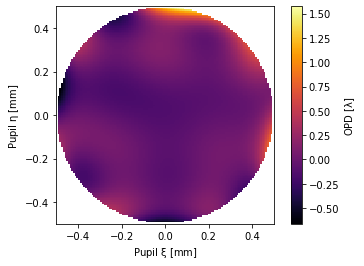

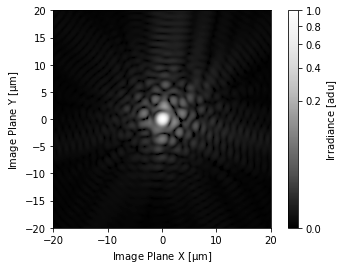

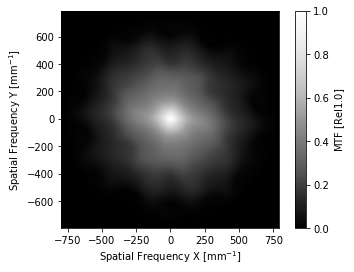

In [3]:
# visualize the pupil's OPD errors
pu.plot2d(interpolation='nearest')  # still mostly works the same - some changes to arguments

# visualize the PSF in 2D
ps.plot2d(xlim=20, power=1/3)  # still mostly works the same- some changes to arguments

# the 2D MTF, the same
mt.plot2d()

The changes here can be summarized as:

- `interp_method` => `interpolation` in plot2d kwargs
- `power` is passed directly through instead of being inverted first.  v0.16 `power=4` => v0.17 `power=1/4`.
- `axlim` is no more on `PSF.plot2d()` - use independent `xlim` and `ylim` args.  `ylim` is adopted from `xlim` if `ylim == None`, and limits are symmetric single values are given, so `xlim=val` functions the same as how `axlim=val` did in v0.16.
- some of the finessed plotting features on PSFs were not used, and work differently (using the `prysm.plotting` module to enhance the basic graphic)
- the axis labels for MTF appear differently, due to the use of astropy.units

On the upside, all three plot2d methods are identical (they are actually `RichData.plot2d()`) now, so there is no need to memorize the differing idiocyncracies of the various `plot2d` functions throughout prysm.  If you wanted to get at some 1D plots, things have also changed.

You might want to slice the PSF:

/Users/bdube/Open Source/prysm/prysm/_richdata.py:401: UserWarning: .slice_x is deprecated and will be removed in prysm v0.18, please use .slices().x
  warnings.warn('.slice_x is deprecated and will be removed in prysm v0.18, please use .slices().x')


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10401a210>)

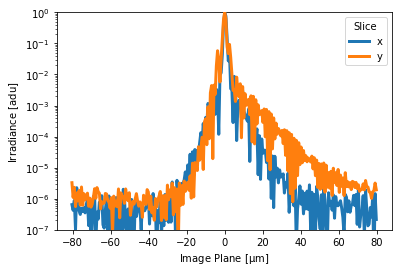

In [4]:
# we're not going to do anything with this, just showing it still works for now
x, val = ps.slice_x
x, val = ps.slices().x  # this is the new syntax, still not going to do anything with this...

# ps.plot_slice_xy()  # <- this will error and does not exist anymore
ps.slices().plot(['x', 'y'], yscale='log', ylim=(1e-7,1e0))  # <- this is the new (equivalent) syntax
# albeit with a little bit extra to do lot axes

Or you probably want to look at the MTF in 1D:

/Users/bdube/Open Source/prysm/prysm/otf.py:165: UserWarning: .tan is deprecated and will be removed in v0.18, please use .slices().x
  warnings.warn('.tan is deprecated and will be removed in v0.18, please use .slices().x')
/Users/bdube/Open Source/prysm/prysm/otf.py:174: UserWarning: .exact_tan is deprecated and will be removed in v0.18, please use .exact_x
  warnings.warn('.exact_tan is deprecated and will be removed in v0.18, please use .exact_x')


array(0.46429075)

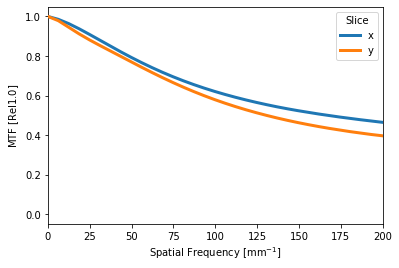

In [5]:
# this won't run anymore
# mt.plot_tan_sag()
mt.slices().plot(['x', 'y'], xlim=(0,200)) # this is the new syntax

# this warns for now, but will error in v0.18
mt.tan  # not going to do anything with it...

mt.exact_tan(200)  # ~0.5

We won't show anything for plotting the pupil in 1D, since that is a fairly corner-case usage.  The changes are identical to the ones to `PSF`.  Of note is that:

- much the same as with `plot2d`, 1D plotting (and access) is now univeral with a single API for all objects
- `.slice_x` and `_y` if they existed now warn and point to the modern syntax
- `.tan` and `.sag` do the same
- `max_freq` is no more and is replaced with `xlim` under the universal plotting grammar

Turning to working with interferometer data, we can load and touch up an interferogram the same as always:

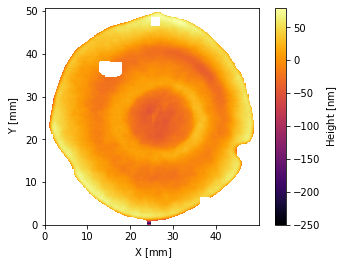

In [6]:
i = Interferogram.from_zygo_dat(sample_files('dat'))
i.crop().remove_piston_tiptilt_power()
i.plot2d()
i.fill()

The only substantial changes here are to working with PSD and with plotting.  Plotting changes are the same as for above so we will not go over them.  For PSD in 2D:

In [7]:
# v0.16
# ux, uy, psd = i.psd()

# v0.17
# PSD objects are descendants of RichData like anything else,
# and `.psd` returns an object instead of the arrays themselves
# the object brings PSD into the core vocabulary of the library
psd = i.psd()
ux, uy, psd_ = psd.x, psd.y, psd.data

It is probably somewhat unusual that you want to directly access the arrays, but they're in the same place they are on any other prysm object.  If you wanted to plot in 2D:

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1c292350>)

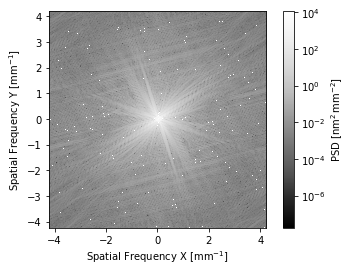

In [8]:
# v0.16
# i.plot_psd2d()

# v0.17
i.psd().plot2d(log=True)  # could use the psd object above, too...

Or in 1D:

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1d90ec10>)

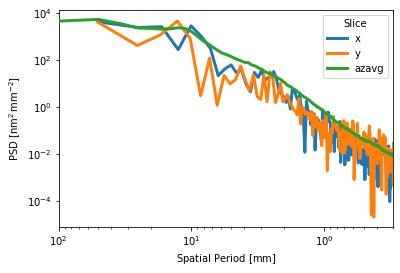

In [9]:
# v0.16
# i.plot_psd_slices()

# v0.17
i.psd().slices().plot(['x', 'y', 'azavg'], invert_x=True, xlim=(0.3, 100))

Applying PSD power laws is covered in the [user's guide](../user_guide/Interferograms.html)

Direct access to the slices changes similarly:

In [10]:
# v0.16
# i.psd_slices()['x'] or ['y'], etc

# v0.17
s = i.psd().slices()
s.x, s.y; # and so on

The changes here can be summarized as:

- `.psd()` now returns an object instead of arrays.
- Use that object as you would any othe prysm object to plot or interrogate slices
- use `prysm.plotting` modifiers to add models to the PSD plots

## New Features

After much ado about the changes above, we now move on to the new features of the library.

First we show the new analysis metrics for PSFs:

In [11]:
# FWHM, 1/e, 1/e^2
ps.fwhm(), ps.one_over_e(), ps.one_over_e2()

(0.8716122058823547, 0.8703811151960802, 1.1756916053921591)

Units are now farmed out to `astropy.units`, which means you can do things like the following:

Angstrom
mm


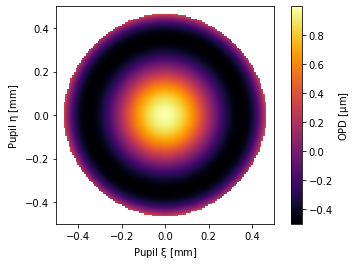

In [12]:
from astropy import units as u

pu2 = NollZernike(Z11=1, z_unit=u.um)
pu2.plot2d()

pu3 = NollZernike(Z6=1, z_unit=u.AA)
print(pu3.z_unit)

pu4 = NollZernike(Z3=1, z_unit='mm')  # prysm maps strings to astropy units for you
print(pu4.z_unit)

These are all properly converted when classes interact:

In [13]:
ps2 = PSF.from_pupil(pu2, 2)
ps3 = PSF.from_pupil(pu3, 2)

ps2.fwhm() > ps3.fwhm()  # 1 um of WFE is much blurrier than 1 angstrom

True

Plotting now has a universal grammar as shown above, where all classes have the same `.plot2d()` and `.slices().plot()` functions.  Note that:

- classes have a ._default_twosided cls attribute which controls whether the slices default to being twosided or one-sided.  The default value usually aligns with what you want, but you could change it either on a case-by-case basis in the argument to `.slices()`, or by overwriting the cls attribute.
- azimuthal slices are inherently one sided and have minimum values of ~0 for the radial parameter `r`.

Two new Zernike formalisms are supported, `ANSI1TermZernike` and `ANSI2TermZernike`.  Both of these quack like the other Zernike classes, with the change of the two-term option taking `A` and `B` coefficients (cosine / m+, sine / m-) that separate `n` and `m` by an underscore.  Each supports expansion up to arbitrary order (at least n > 1000 is tested) without numerical precision issues or other errors.

They are implemented on top of recursive Jacobi polynomials and afford some speed benefit over the older Zernike implementation (2-3x for common orders, increasing with incresing order).  They are also cached just as the older Zernike implementation.  In v0.18, the older zernike implementation will be refactored to be based on this one.  Performance is constant time when using the caches.  On the laptop this documentation was written on, a 2048x2048 grid of points for a Zernike term of arbitrary order can be generated in approximately 20 ms.  At 256x256 the time is approximately 0.5 ms.

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x103ffe910>)

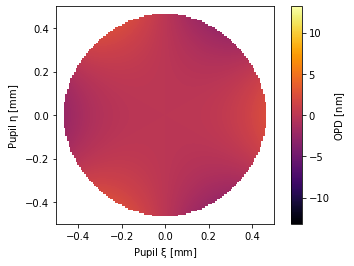

In [14]:
from prysm import ANSI1TermZernike, ANSI2TermZernike

# some trefoil and 91-foil, As are cosines and Bs are sines
pu = ANSI2TermZernike(A3_3=1, B91_91=1)
pu.plot2d()

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1b632950>)

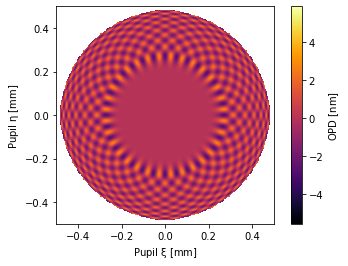

In [15]:
# 2000th zernike term!
pu = ANSI1TermZernike(Z2000=1, samples=256)
pu.plot2d(interpolation=None)

In [16]:
# free memory for QBFS and QCon examples
ANSI1TermZernike._cache.clear()
ANSI2TermZernike._cache.clear()

Greg Forbes' Q polynomials are also implemented, again based on recursive Jacobi polynomials and supporting unlimited order.  The QCon polynomials have similar performance to ANSI Zernike polynomials (within about 10%).  The Qbfs polynomials have an extra 2 terms in their recurrence relation and are about 40-50% slower as a consequence.  That said, performance is still on the order of a millisecond for a 256x256 grid at any order.

In [17]:
from prysm import QCONSag, QBFSSag
from prysm.qpoly import QBFSCache, g_qbfs, h_qbfs, f_qbfs

from matplotlib import pyplot as plt

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1dc3c650>)

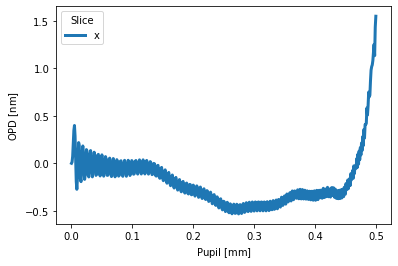

In [18]:
# some crazy oscillations put in with a 250th order Qcon term
pu = QCONSag(A1=1, A3=0.5, A15=0.1, A250=1, samples=1024)
pu.slices(twosided=False).plot('x')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1c35dd50>)

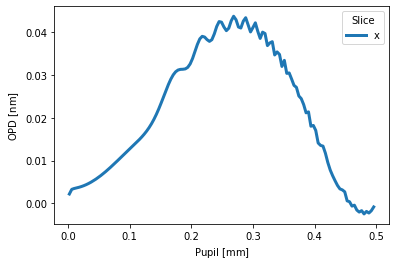

In [19]:
# some crazy oscillations put in with a 400th order Qbfs term
# these are 'real' and not a numerical artifact
pu = QBFSSag(A0=0.01, A1=0.1, A400=1, samples=256)
pu.slices(twosided=False).plot('x')

Perhaps you may wonder how many pixels are needed to sample a given Zernike term.  This can be calculated now:

In [20]:
from prysm.zernike import zero_separation

2 * 1 / zero_separation(n=4)  # primary spherical

32.0

In [21]:
2 * 1 / zero_separation(n=20)  # 20th order spherical

800.0